### Y-data

In [24]:
import pandas as pd
from utils.load import make_total_df
import country_converter as coco
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [59]:


distance_df = pd.read_excel('dist_cepii.xls')

# Changing country codes from iso3 to iso2
iso3_codes = distance_df['iso_o'].to_list()
iso2_codes_list = coco.convert(names=iso3_codes, to='ISO2', not_found='NULL')
distance_df['iso_o'] = iso2_codes_list
distance_df = distance_df.drop(distance_df.loc[distance_df['iso_o'] == 'NULL'].index)

iso3_codes = distance_df['iso_d'].to_list()
iso2_codes_list = coco.convert(names=iso3_codes, to='ISO2', not_found='NULL')
distance_df['iso_d'] = iso2_codes_list
distance_df = distance_df.drop(distance_df.loc[distance_df['iso_d'] == 'NULL'].index)
distance_df["iso_o"] = distance_df["iso_o"] + '_' + distance_df["iso_d"]

distance_df = distance_df[['iso_o', 'dist']]

friendship_data = pd.read_csv("data/friendship_data/countries-countries-fb-social-connectedness-index-october-2021.tsv", delimiter="\t")
friendship_data['scaled_sci'] = np.log2(friendship_data['scaled_sci']+1)
#friendship_data = friendship_data.round({'scaled_sci'})
friendship_data["user_loc"] = friendship_data["user_loc"] + '_' + friendship_data["fr_loc"]

friendship_data['friend_rank'] = range(1, len(friendship_data) + 1)
f_df = friendship_data.sort_values(by="scaled_sci", ascending=False)
distance_df['dist_rank'] = range(1, len(distance_df) + 1)
d_df = distance_df.sort_values(by="dist", ascending=False)

y_df = pd.merge(left=f_df, right=d_df, how='left', left_on='user_loc', right_on='iso_o')
y_df = y_df.dropna()





    


ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not found in ISO3
ANT not fo

In [60]:
distance_df.head

<bound method NDFrame.head of        iso_o          dist  dist_rank
0      AW_AW      5.225315          1
1      AW_AF  13257.810000          2
2      AW_AO   9516.913000          3
3      AW_AI    983.268200          4
4      AW_AL   9091.742000          5
...      ...           ...        ...
50169  ZW_WS  14465.200000      47520
50170  ZW_YE   3971.474000      47521
50172  ZW_ZA   2186.206000      47522
50174  ZW_ZM    396.804100      47523
50175  ZW_ZW    235.119300      47524

[47524 rows x 3 columns]>

Text(0, 0.5, 'y')

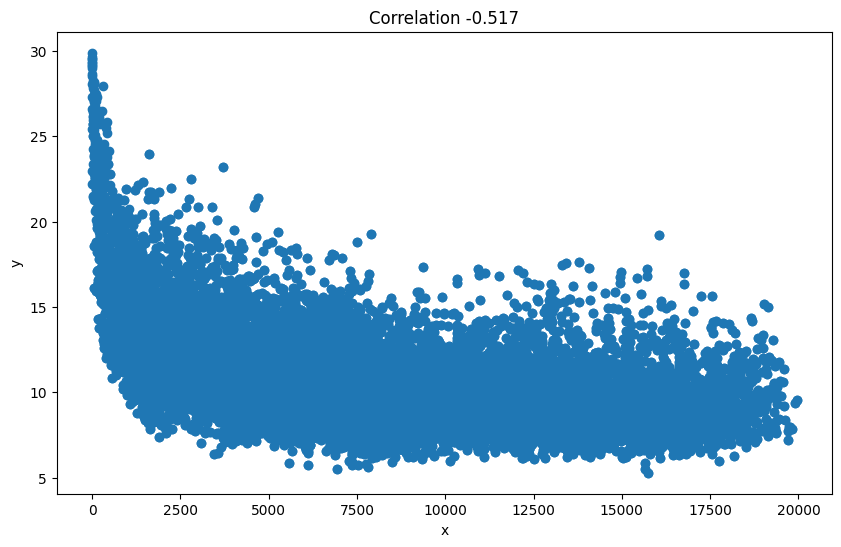

In [27]:
x = y_df['dist']
y = y_df['scaled_sci']
pearsonr(x, y)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(x, y)
# construct title
title = f"Correlation {pearsonr(x, y)[0]:.3f}"
#if print_spearman_correlation:
  #  title += f", Spearman correlation {spearmanr(x, y)[0]:.3f}"
ax.set_title(title)
ax.set_xlabel("x")
ax.set_ylabel("y")


AttributeError: module 'seaborn' has no attribute 'title'

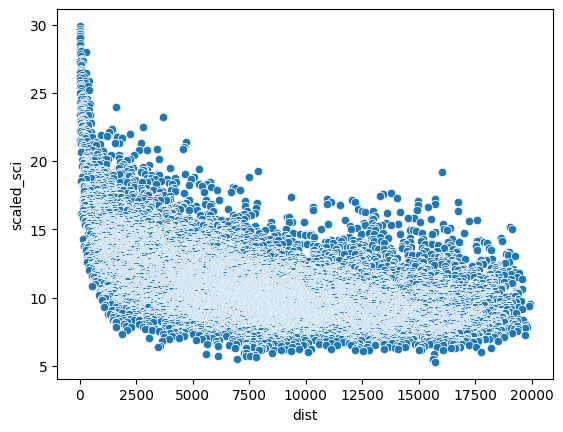

In [28]:
sns.scatterplot(x=x, y=y)
sns.title("test")

### X-data

In [15]:
x_data = make_total_df()
x_df = pd.merge(left=x_data, right=d_df, how='left', left_on='c_to_c', right_on='iso_o')
x_df = x_df.dropna()


In [17]:
dist = x_df['dist'].to_list()
#friend_rank = y_df['friend_rank'].to_list()


In [33]:

for (columnName, columnData) in x_df.iteritems():

    if is_numeric_dtype(columnData):
        c = columnData.to_list()
        correlation, pvalue = pearsonr(c, dist) 
        if correlation > :
            print(columnName)
       # print(f'{columnName}: {correlation : .4f}, significant: {pvalue <= 0.01}')



/var/folders/jv/cmw96wbs0_72bmk_p4vxvdy40000gn/T/ipykernel_95244/3973012699.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (columnName, columnData) in x_df.iteritems():


FBCosDist_People.
FBCosDist_SportsOutdoors.
dist


In [69]:
for c in x_data.columns[:-1]:
 if is_numeric_dtype(x_data[c]):
  correlation, pvalue = pearsonr(x_data[c], ) 
  print(f’{c}: {correlation : .4f}, significant: {pvalue <= 0.05}’)

SyntaxError: invalid character '’' (U+2019) (3942372697.py, line 1)

In [36]:
from utils.load import load_everthing_old
X_dict, Y_dict = load_everthing_old()

X = list(X_dict.values())
#X = preprocessing.normalize(X)

y = [x[0] for x in Y_dict.values()]
y = np.log10(y)


In [149]:
y_data = x_df["Y_labels"]
features = x_df.drop(['Y_labels','iso_o','dist_rank'], axis=1)
features = np.log10(features)


In [165]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, y_data,test_size=0.2, random_state=42)


In [166]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler().fit(X_train)



X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)

In [167]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)
cpts = pd.DataFrame(pca.transform(X_train))
x_axis = np.arange(1, pca.n_components_+1)
pca_scaled = PCA()
pca_scaled.fit(X_train_scaled)
cpts_scaled = pd.DataFrame(pca.transform(X_train_scaled))


In [168]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)

In [3]:
from src.Visualisations.Continents.continents_friend import continent_connections_plot, split_social_continent
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

      user_loc fr_loc  scaled_sci  region
740         AO     AE        2326  Africa
741         AO     AG        4539  Africa
742         AO     AL         689  Africa
743         AO     AM         298  Africa
744         AO     AO    16815996  Africa
...        ...    ...         ...     ...
34220       ZW     XK         262  Africa
34221       ZW     YT        1650  Africa
34222       ZW     ZA      366466  Africa
34223       ZW     ZM      196035  Africa
34224       ZW     ZW    20247600  Africa

[9620 rows x 4 columns]


In [4]:


continent_dfs = split_social_continent()
asia = continent_dfs['Asia']
america = continent_dfs['Americas']
europe = continent_dfs['Europe']
oceania = continent_dfs['Oceania']
africa = continent_dfs['Africa']

frames = [asia, america, europe,oceania,africa]
df = pd.concat(frames)


#sns.catplot(data=df, x="region", y="scaled_sci",kind="swarm")



In [7]:
df

,user_loc,fr_loc,scaled_sci,region
0,AE,AE,1117179,Asia
1,AE,AG,5488,Asia
2,AE,AL,2101,Asia
3,AE,AM,3580,Asia
4,AE,AO,2326,Asia
...,...,...,...,...
34220,ZW,XK,262,Africa
34221,ZW,YT,1650,Africa
34222,ZW,ZA,366466,Africa
34223,ZW,ZM,196035,Africa


In [8]:
sns.displot(df, x="scaled_sci", hue="region")
